In [111]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

IMG_DIRECTORY = "./../images/"

to_zip = []

In [112]:
# Function to get all sundays of a particular year

def allsundays(year):
    return pd.date_range(start=str(year), end=str(year+1), 
                         freq='W-SUN').strftime('%m/%d/%Y').tolist()

In [113]:
# Gets the list of all folders present in the images folder
img_list = sorted(os.listdir(IMG_DIRECTORY))

# On analysis, we've found that each image is comprised of only 7 colors given here
# Order of colors - dark red, gray, light blue, red, orange, yellow, white
unique = [[150,0, 0], [150, 150, 150], [200, 250, 250], [240, 0, 0], [250, 170, 10], [255, 240, 0],  [255,255, 255]]

# For easier computation, here are the grayscale values of the colors
# Order of the colors - dark red, ,gray
gray_vals = [44, 150, 235, 71, 175, 217, 254]

# Stores all the data
all_data = []

dates = []

# size of each region into which the image will be divided
pacific_size = 3600*2200
asia_atlantic_size = 3600*3300
aus_size = 3500*1700

# list of all the sizes for better referencing in code
region_sizes = [pacific_size, asia_atlantic_size, aus_size]

# folder here corresponds to the year
for folder in img_list:
    name = IMG_DIRECTORY + "/" + folder + "/ct5km_baa-max-7d_v3.1_" + folder

    # Stores all the data for a year
    year_data = []

    # Get all the sundays for this year, store it in the variable 'sundays'
    sundays = allsundays(int(folder))

    # for every sunday
    for day in sundays:

        # split the date
        month, date, year = day.split("/")
        date_sunday = year+"-"+month+"-"+date

        # concatenate to get the file name accordingly
        file = name + month + date + ".png"

        # check that the file exists
        if(os.path.exists(file)):
            dates.append(date_sunday)
            
            # if the file exists, we read it in RGB format, so that computation is lighter
            img = cv2.imread(file,0)

            # dividing the map into 3 regions - the east pacific, asia atlantic (Atlantic and Indian Ocean)
            # and the water bodies around Australia
            pacific = img[:, :2200]
            asia_atlantic = img[:, 2200:5500]
            australia = img[:,5500:]

            parts = [pacific, asia_atlantic, australia]
        
            # Stores all the data for an image of a year
            img_data = []

            # for every region defined
            for part in parts:

                # we get a histogram of the image
                hist, bin_edges = np.histogram(part.ravel(), 255, range=(0,255))

                # To store all the data for a particular region of the original image
                part_data = []

                # We are only interested in getting the histograms for the 7 colors mentioned above
                for color in gray_vals:
                    part_data.append(hist[color])
                
                img_data.append(part_data)

            year_data.append(img_data) 
    all_data.append(year_data)   

In [114]:
# Gets the dimensions and size of the pacific region in our images
pacific_dim = parts[0].shape
pacific_size = pacific_dim[0]*pacific_dim[1]

# Gets the dimensions and size of the pacific region in our images
asia_atlantic_dim = parts[1].shape
asia_atlantic_size = asia_atlantic_dim[0]*asia_atlantic_dim[1]

# Gets the dimensions and size of the pacific region in our images
aus_dim = parts[2].shape
aus_size = aus_dim[0]*aus_dim[1]

# gets the region sizes into a list for easier referencing
region_sizes = [pacific_size, asia_atlantic_size, aus_size]

# To separate the data region wise
pacific_data = []
asia_data = []
aus_data = []

region_data = [pacific_data, asia_data, aus_data]

for i in range(len(all_data)):

    year_wise_data = [[],[],[]]

    for j in range(len(all_data[i])):

        day_wise_data = []

        for k in range(len(all_data[i][j])):

            # converting into probabilities
            color_data_list = (all_data[i][j][k])
            new_list = [x/region_sizes[k] for x in color_data_list]

            day_wise_data.append(new_list)

        year_wise_data[0].append(day_wise_data[0])
        year_wise_data[1].append(day_wise_data[1])
        year_wise_data[2].append(day_wise_data[2])
    
    region_data[0].append(year_wise_data[0])
    region_data[1].append(year_wise_data[1])
    region_data[2].append(year_wise_data[2])

# print(region_data[0][0][0])
# print(all_data)


# By this time, we have separate data of all regions in region_data array in probabolity form

In [115]:
#  Now to create histogram, we need to analyze each color separately, which is done in this section
#  For now, the amount of orange zone in an year is taken to be the avg amount on all sundays

region_avg_data= []

for region in range(len(region_data)):

    avg_data = []

    for year in range(len(region_data[region])):
        
        avg_colors = np.zeros((7,1))
        sum_colors = np.zeros((7,1))

        for day in range(len(region_data[region][year])):

            for color in range(len(gray_vals)):

                sum_colors[color] += region_data[region][year][day][color]
            
        for color in range(len(gray_vals)):
            avg_colors[color] = sum_colors[color]/len(region_data[region][year])

        avg_data.append(avg_colors) 
    
    region_avg_data.append(avg_data)

# print(region_avg_data[0][0])

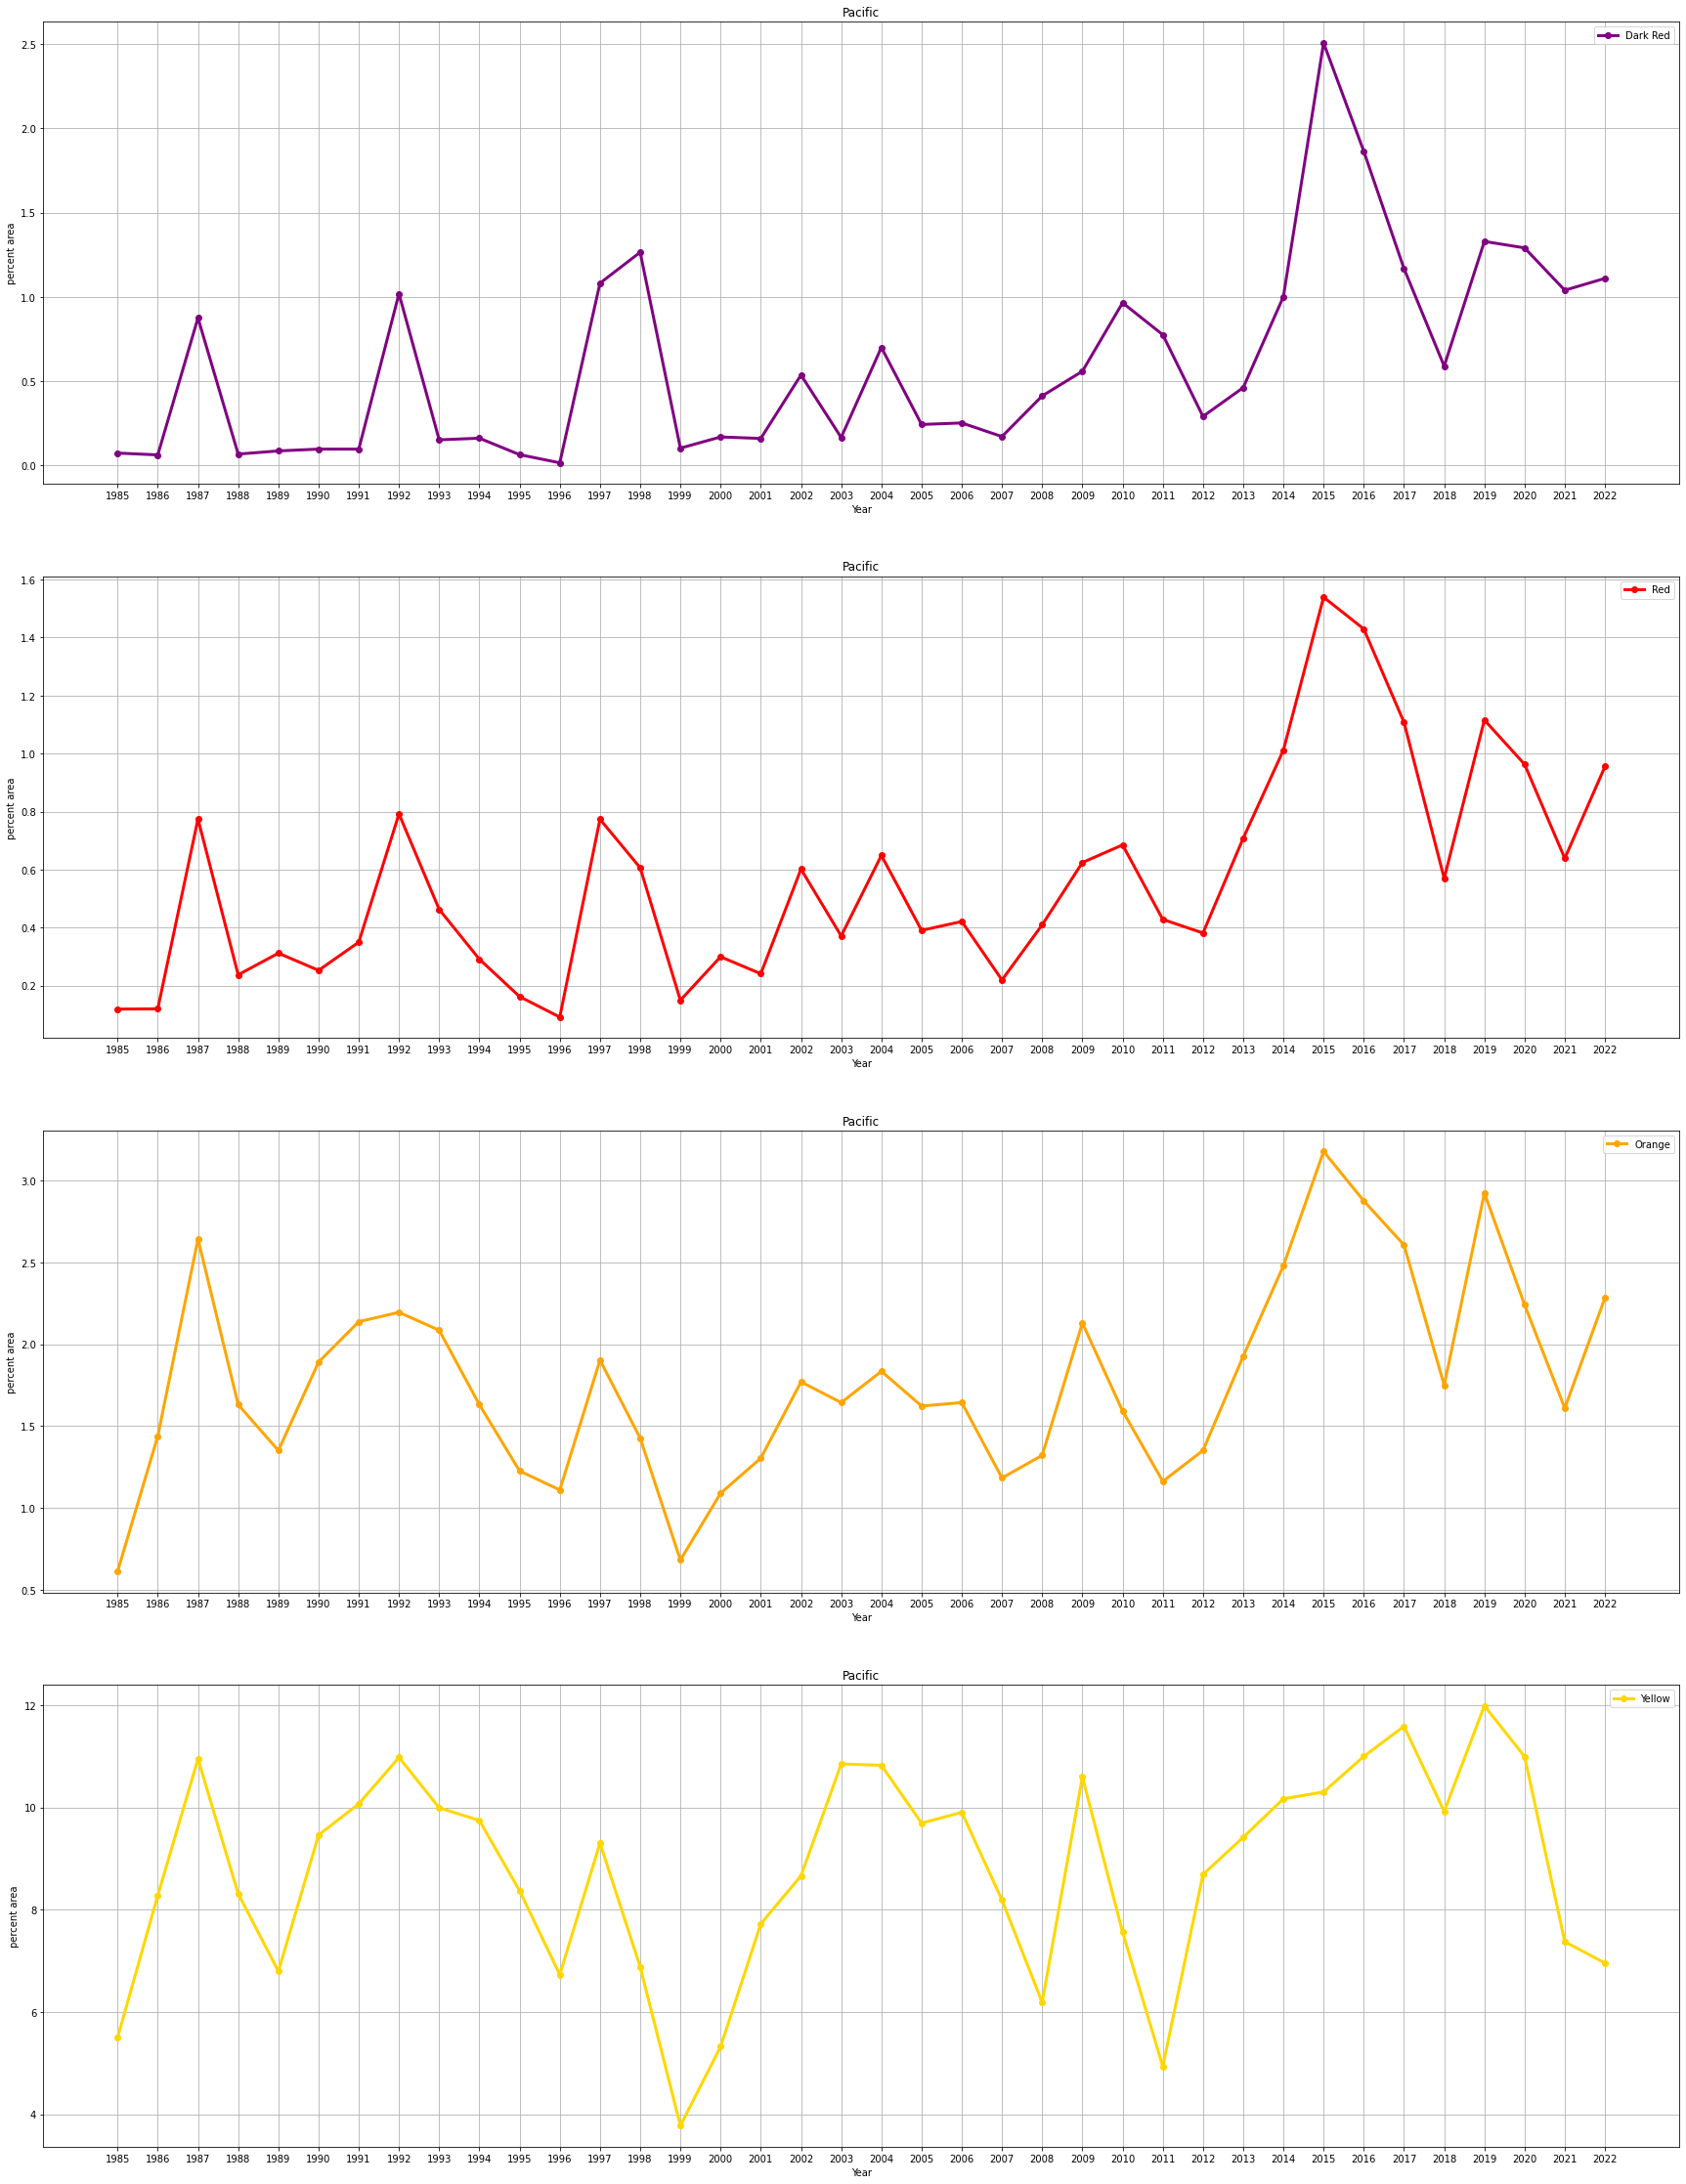

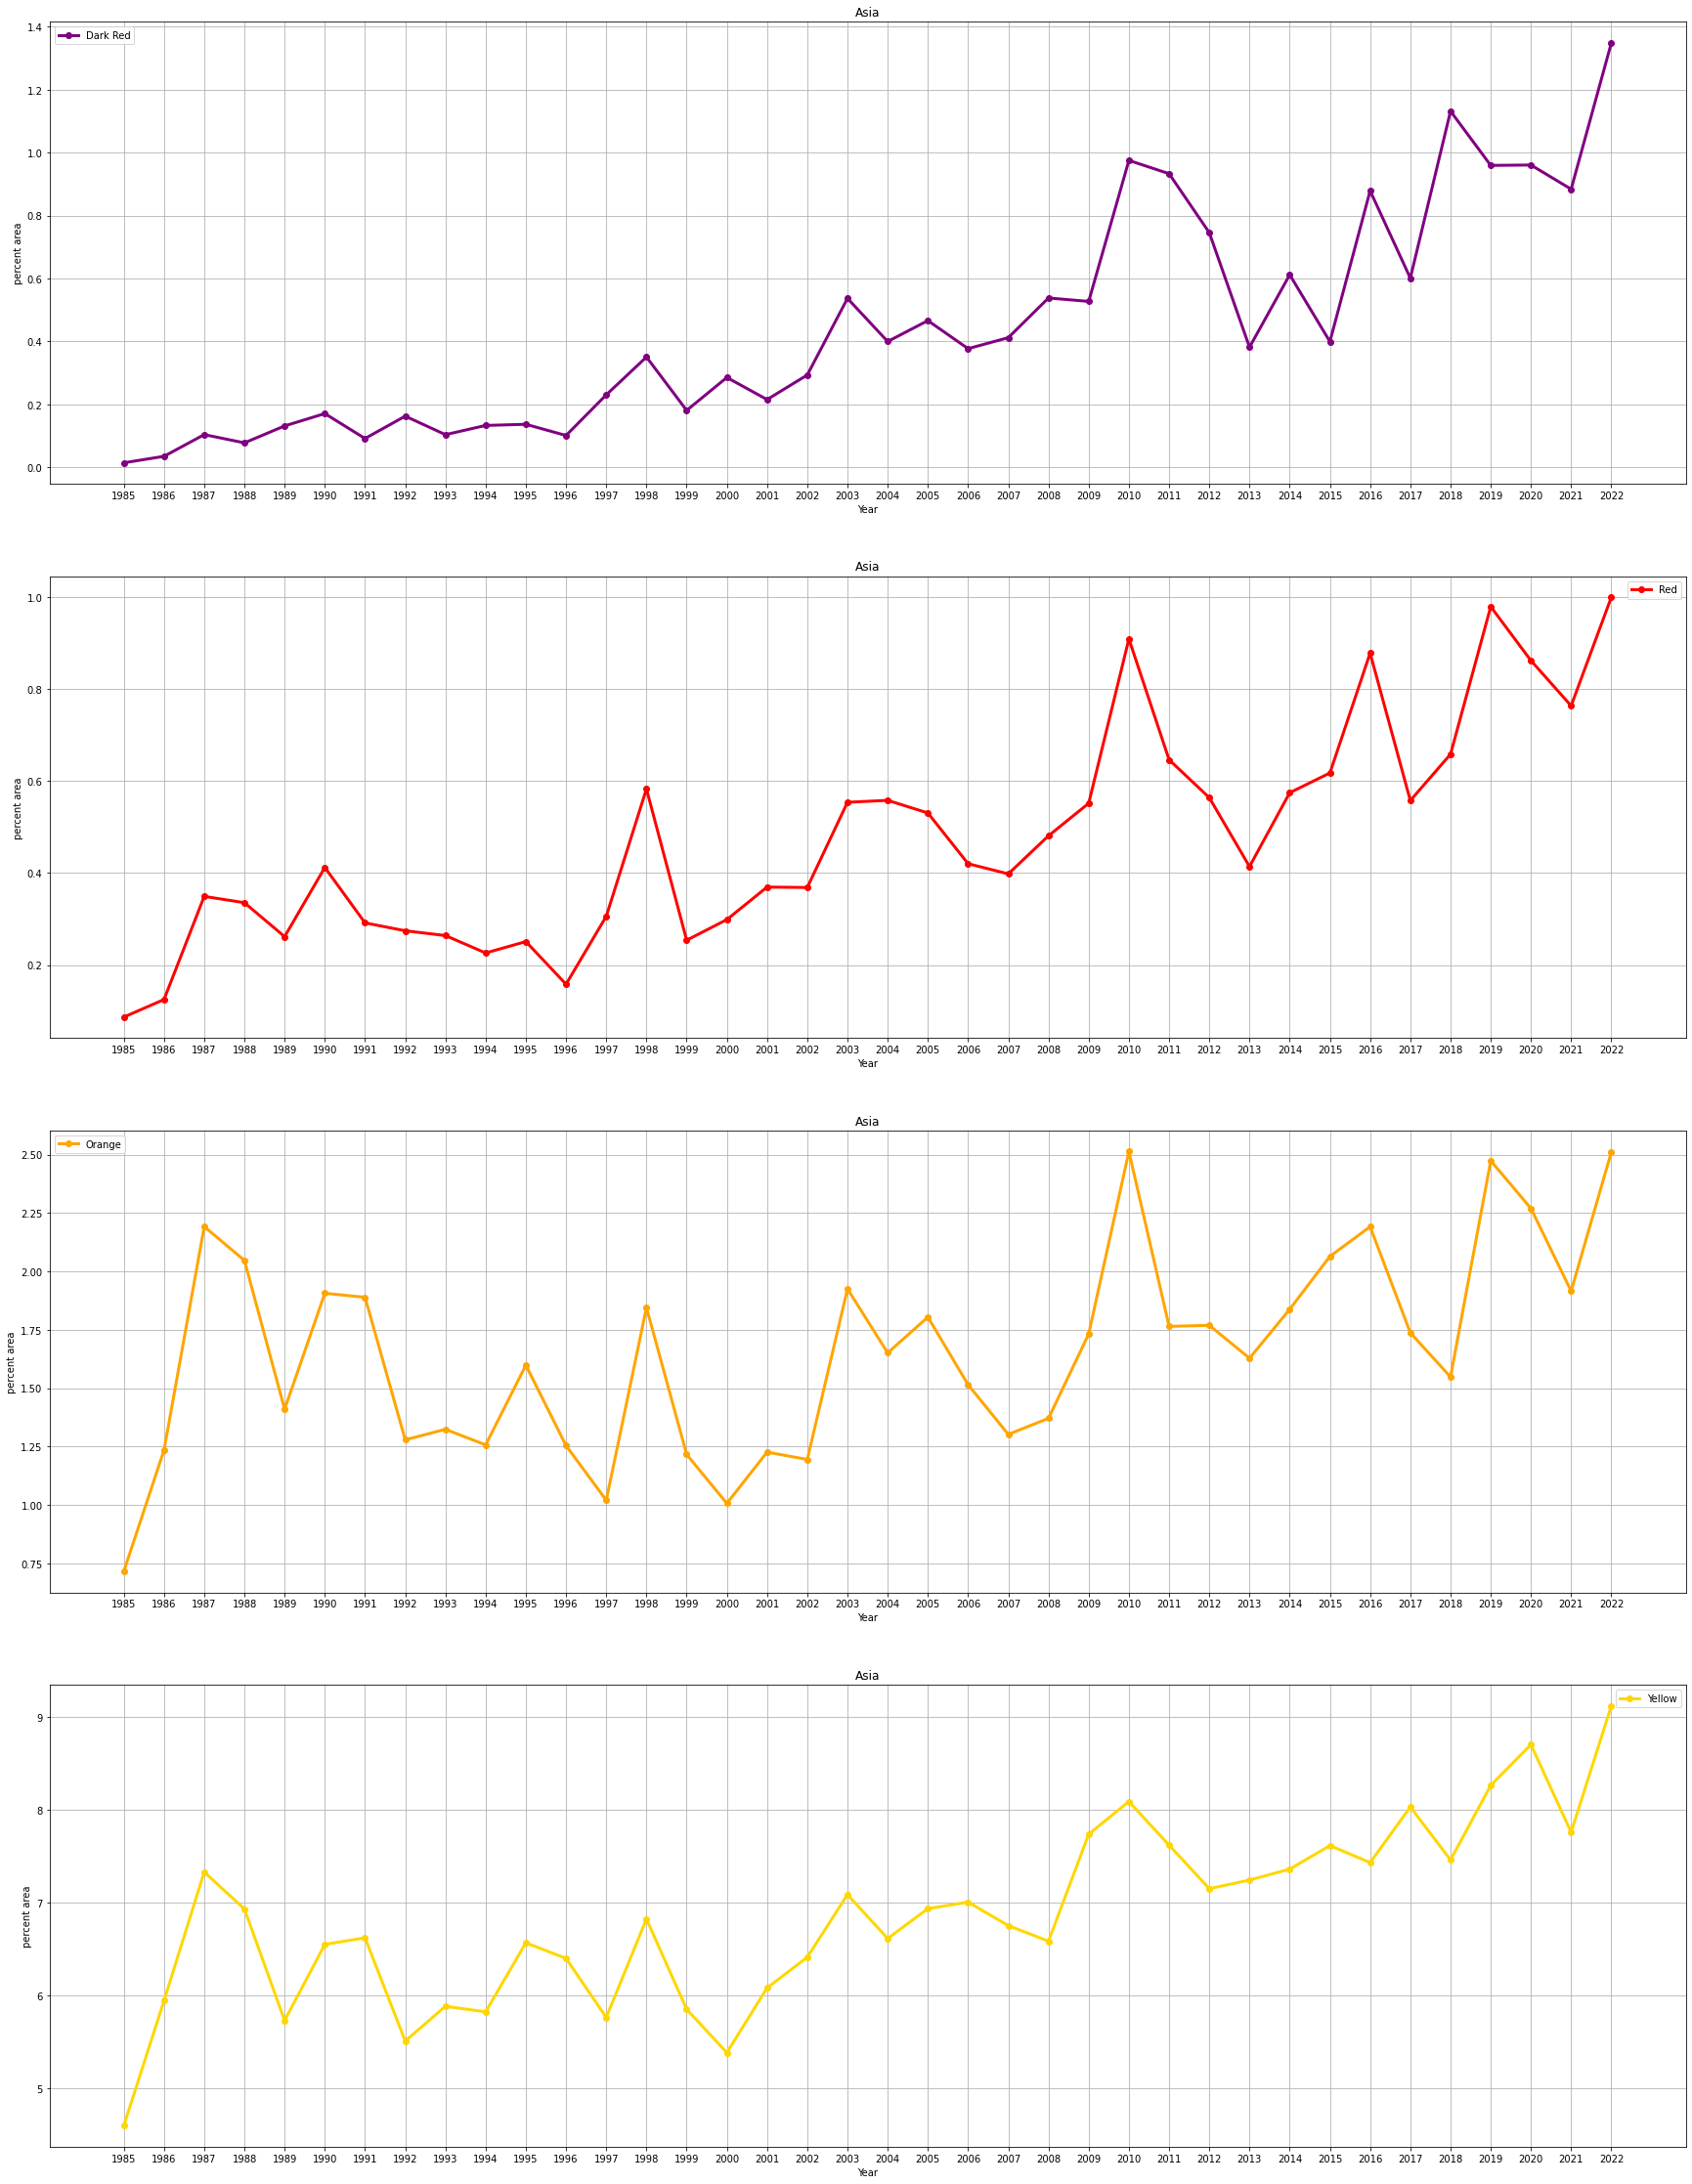

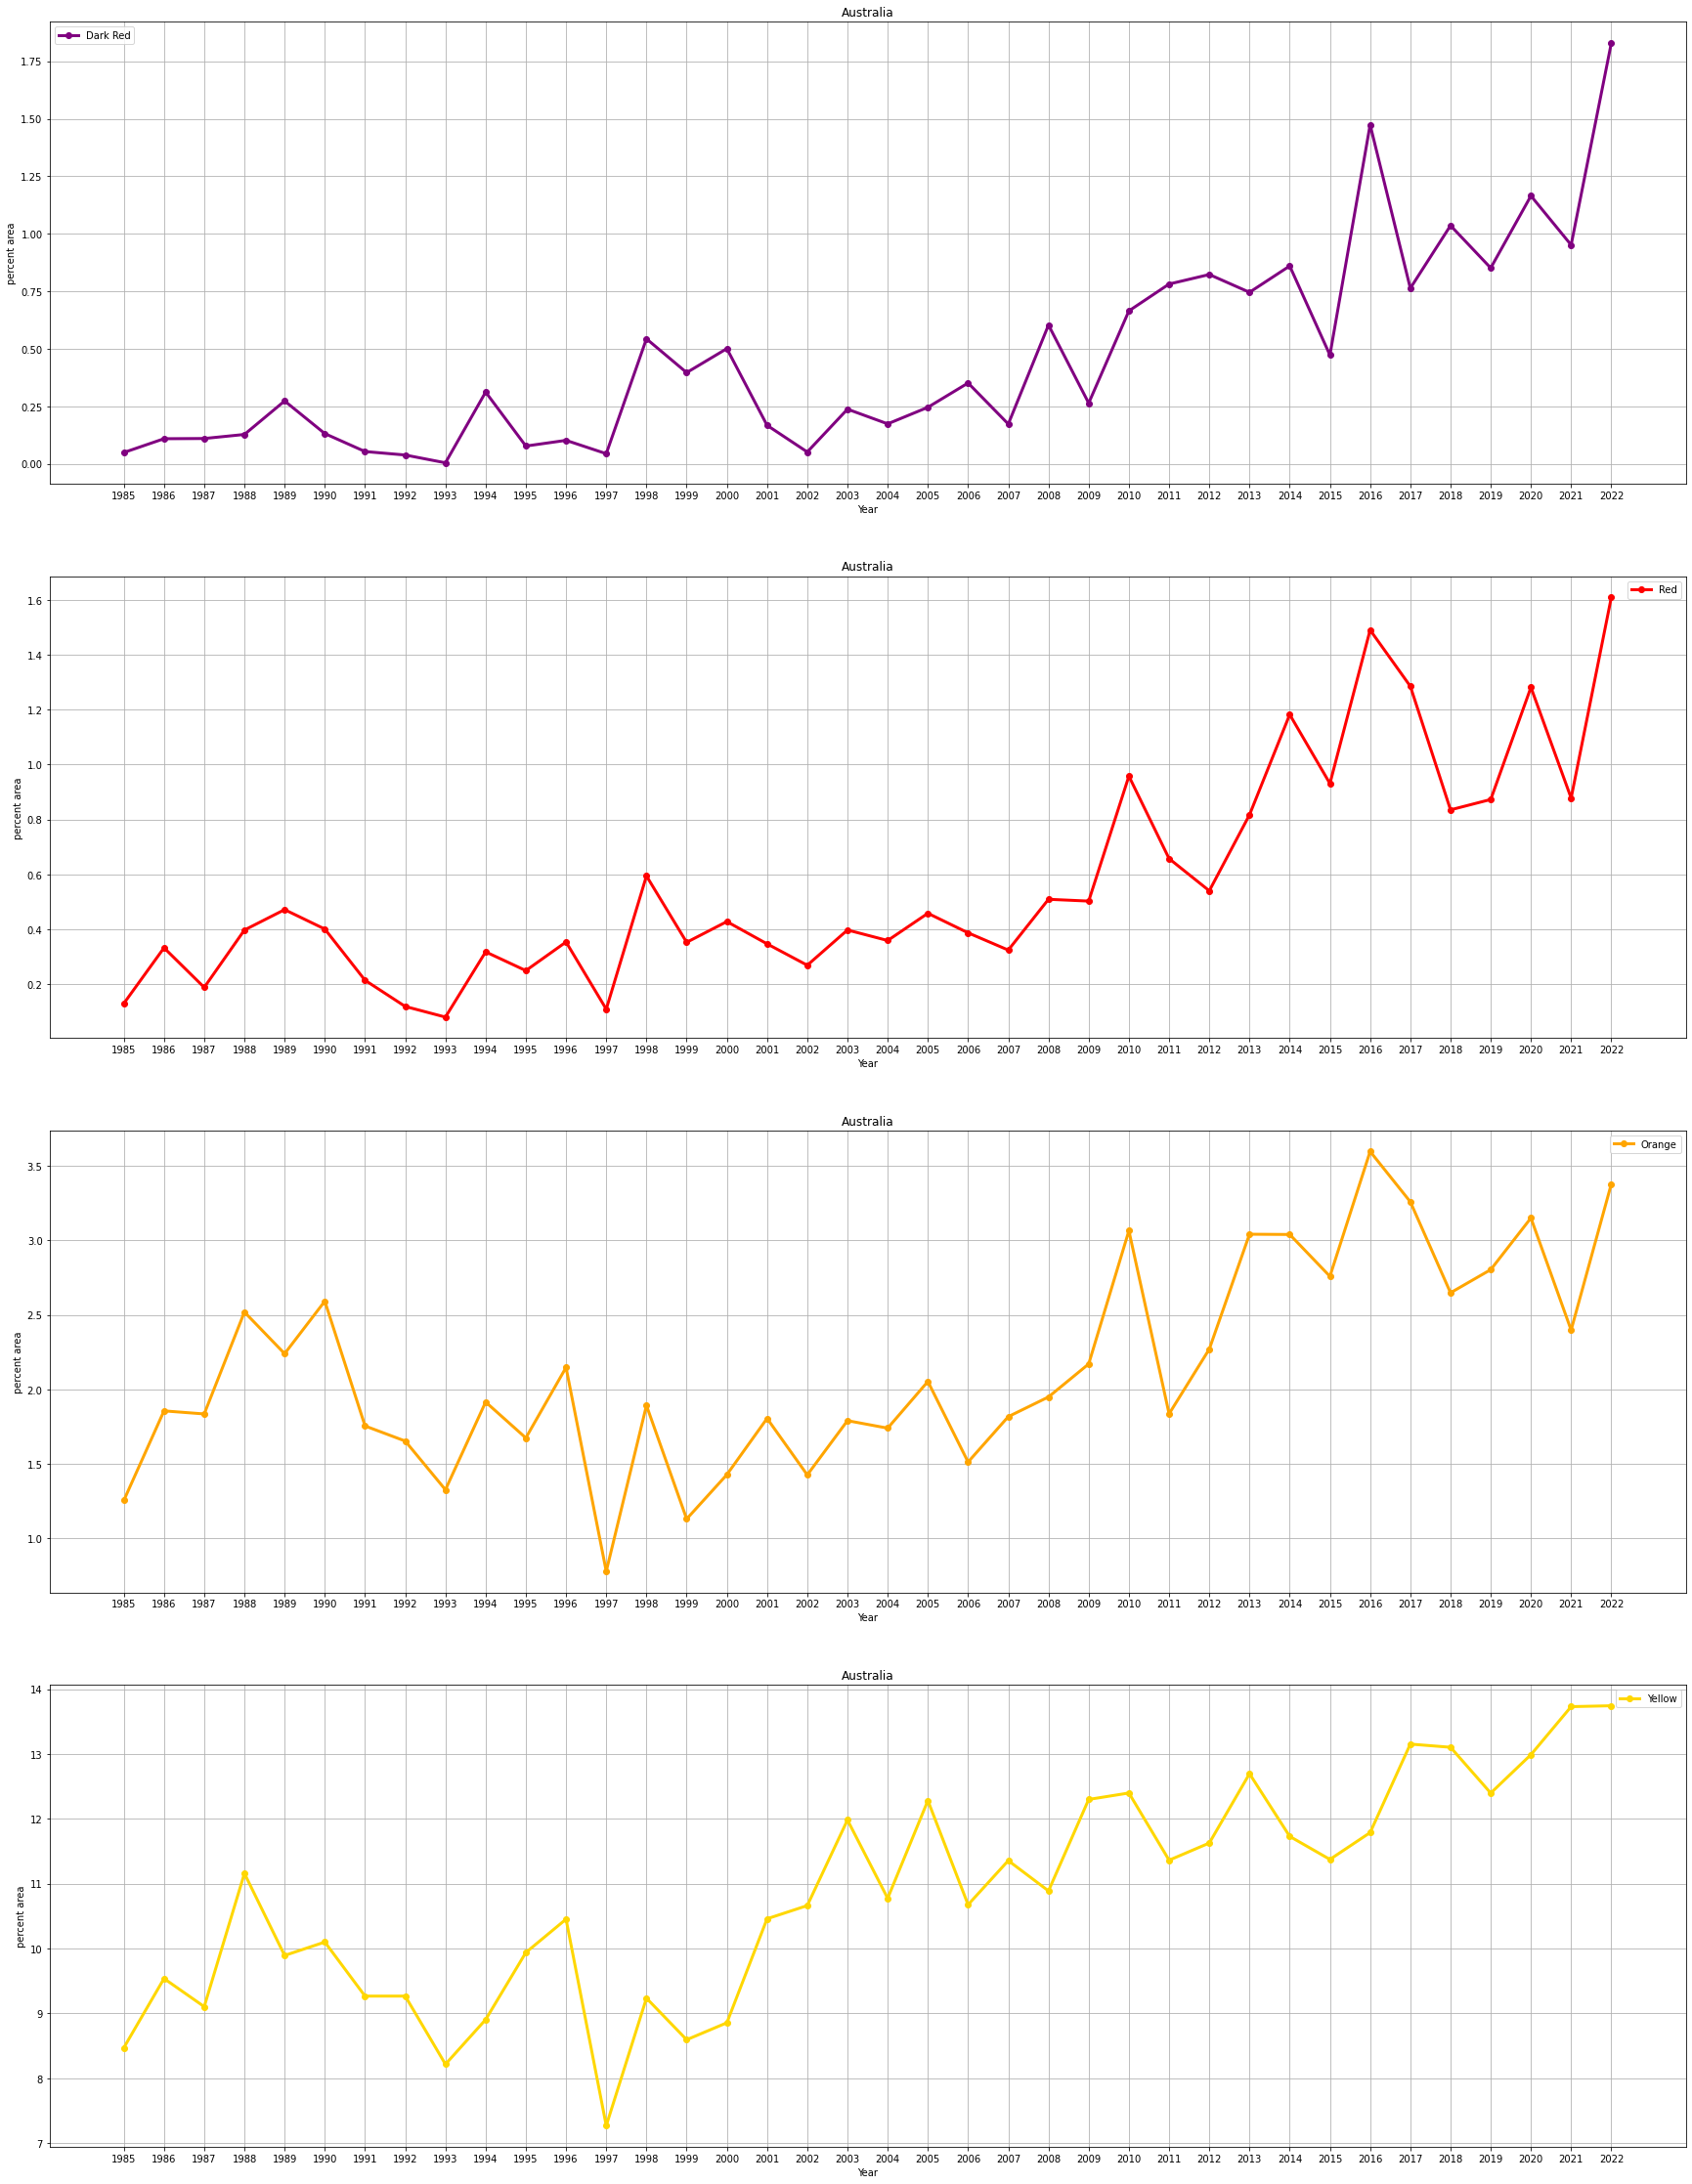

In [116]:
# Plotting the histogram in the order - Pacific, Asia_Atlantic and Aus
import csv

color_desc = ["Dark Red", "Land", "Water", "Red", "Orange", "Yellow", "Ice"]
colors_line = ['purple', '', '', 'red', 'orange', 'gold', 'blue']
regions = ["Pacific","Asia","Australia"]

for region in range(len(region_avg_data)):
    # to_zip.append(np.asarray(img_list))    
    fig = plt.figure(figsize=(30,40))
    j = 1
    for color in range(len(gray_vals)):
        # print(gray_vals[color])
        if color == 1 or color == 2 or color == 6:
            continue
        
        color_avg_over_years = []

        for year in range(len(region_avg_data[region])):

            color_avg_over_years.append(100*region_avg_data[region][year][color])
        plt.subplot(4,1,j)
        plt.plot(img_list, color_avg_over_years, marker='o', label=color_desc[color], color =colors_line[color], linewidth=3.0)
        plt.xlabel("Year")
        plt.ylabel("percent area")
        plt.grid(True)
        plt.title(regions[region])
        plt.legend()
        j += 1
        # to_zip.append(((color_avg_over_years)))
    # to_zip = np.asarray(to_zip).T
    zip(*to_zip)
    # with open(f'{regions[region]}.csv', 'w', ) as myfile:
            # wr = csv.writer(myfile)
            # wr.writerow(["Year", "Dark_red", "red", "orange", "yellow"])
            # wr.writerows(to_zip)

    plt.legend()
    plt.grid(True)
    plt.show()


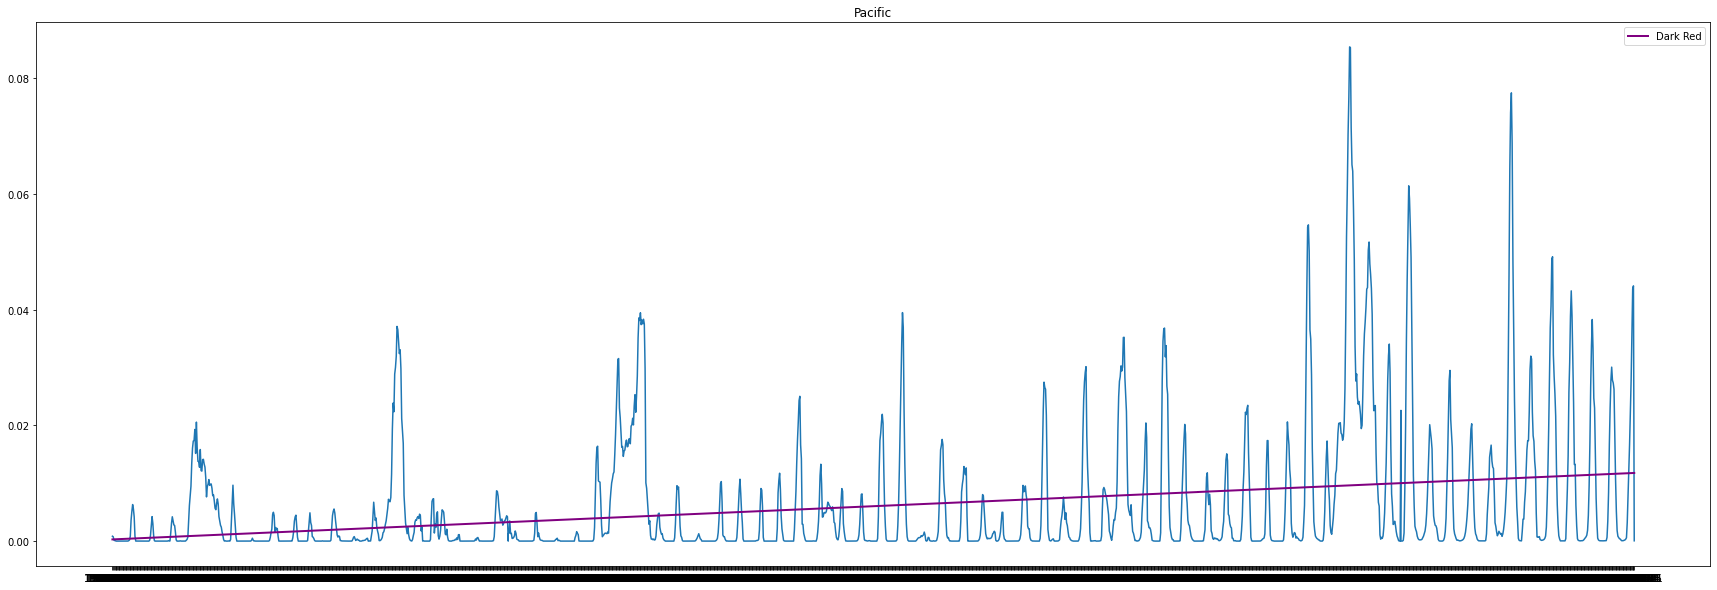

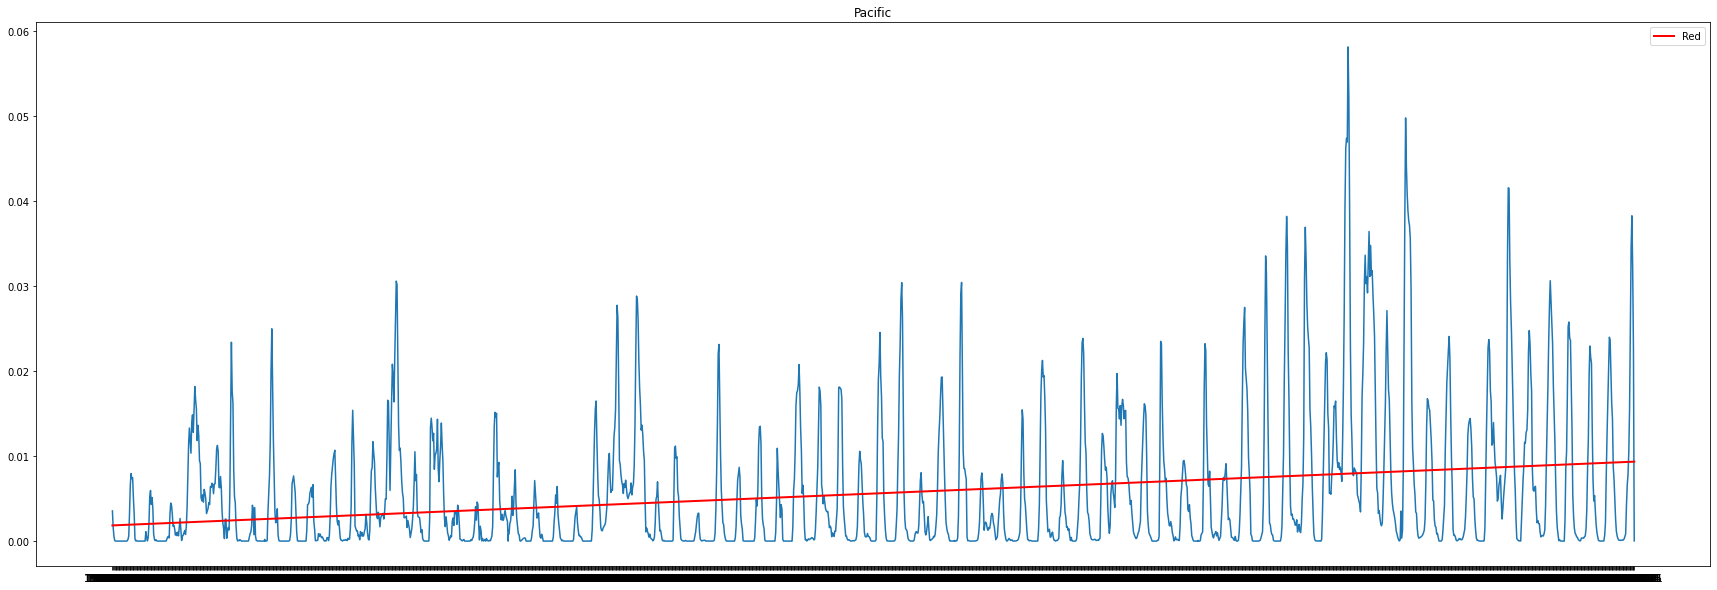

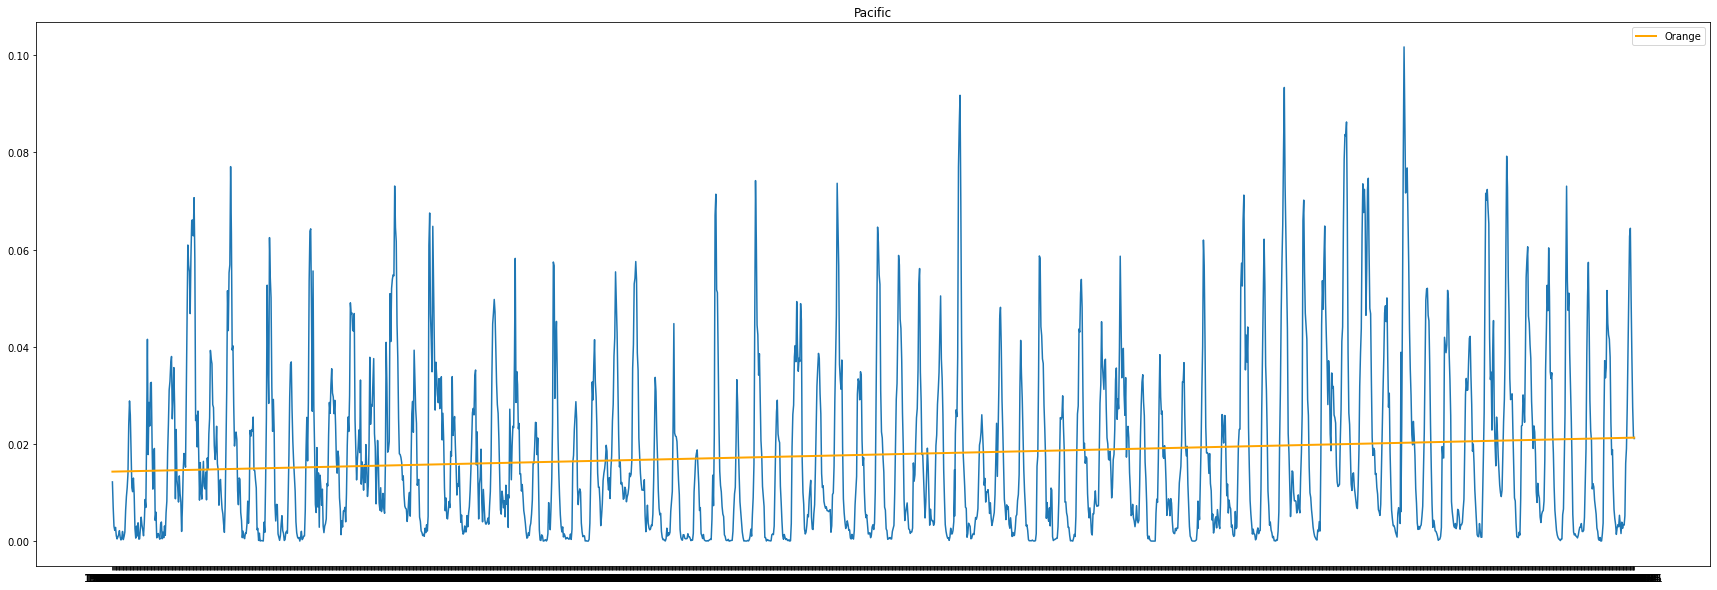

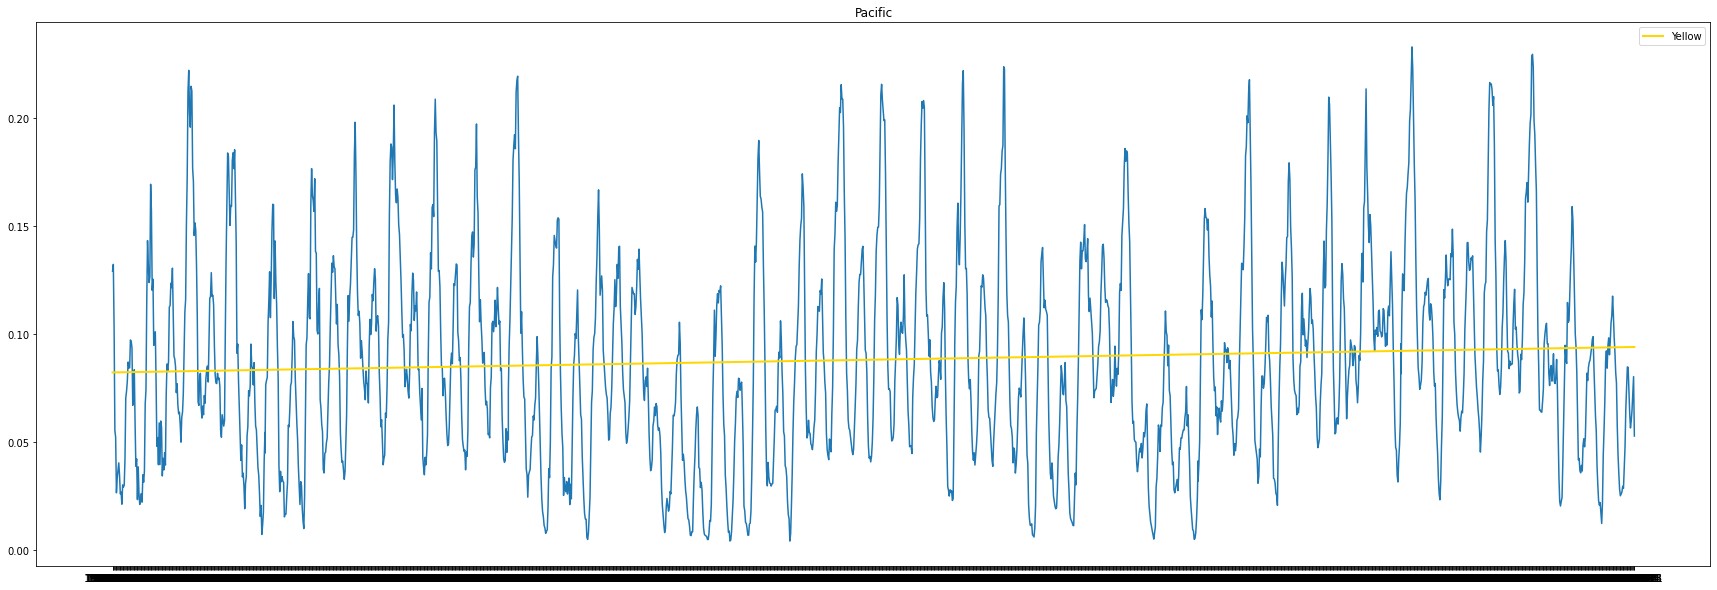

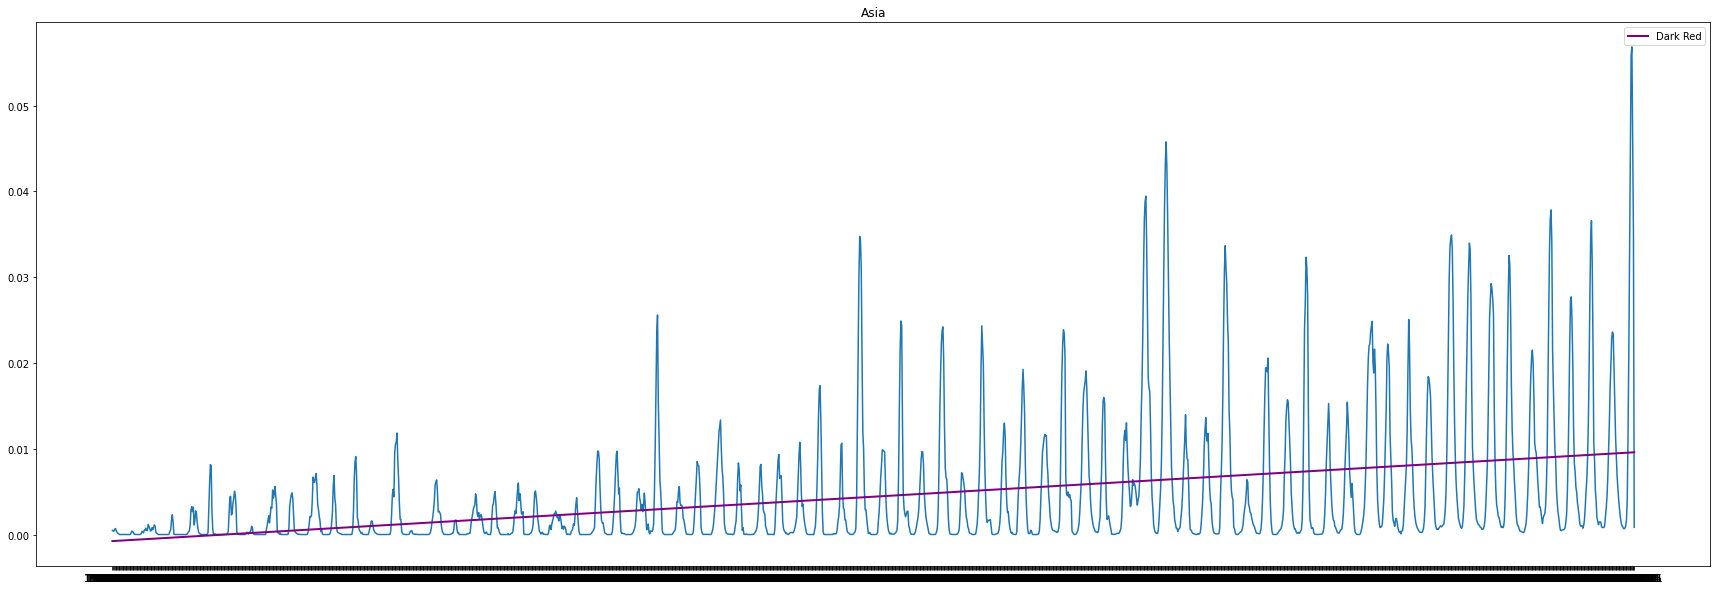

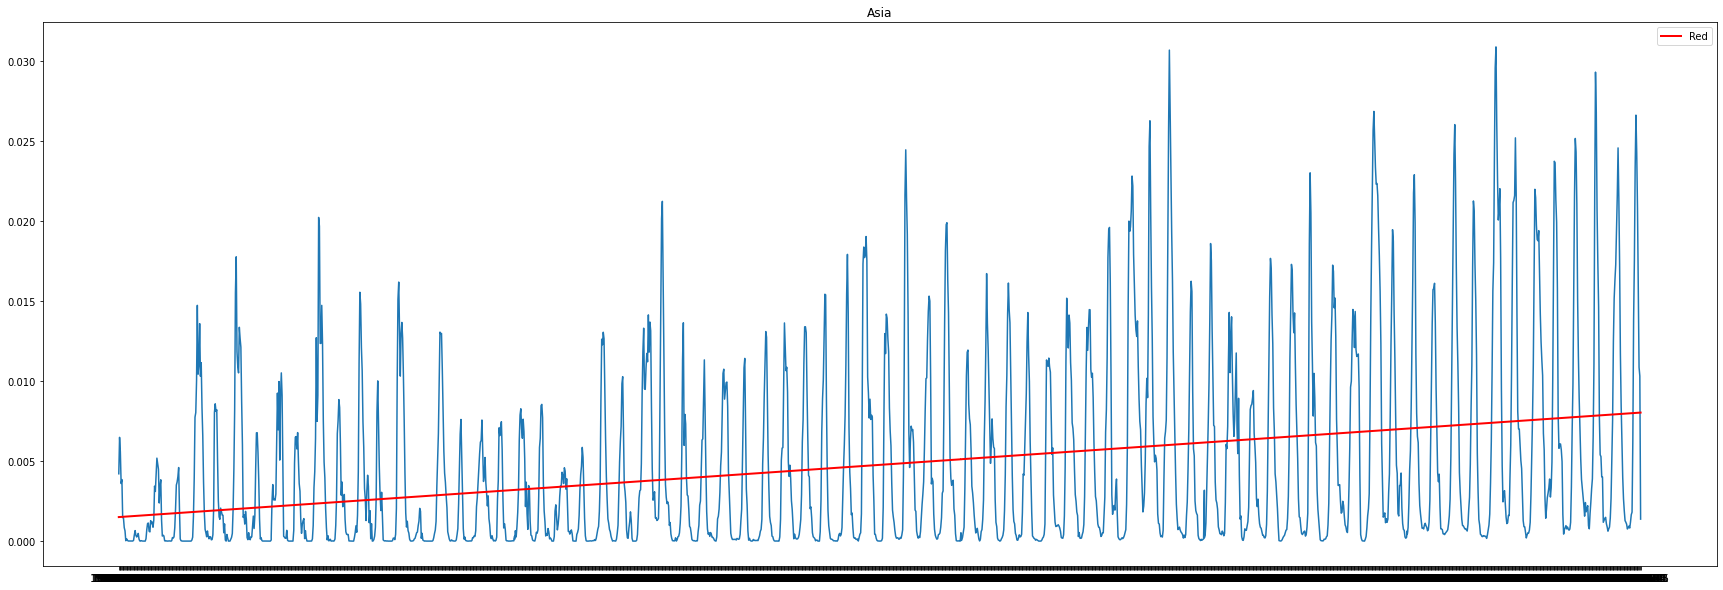

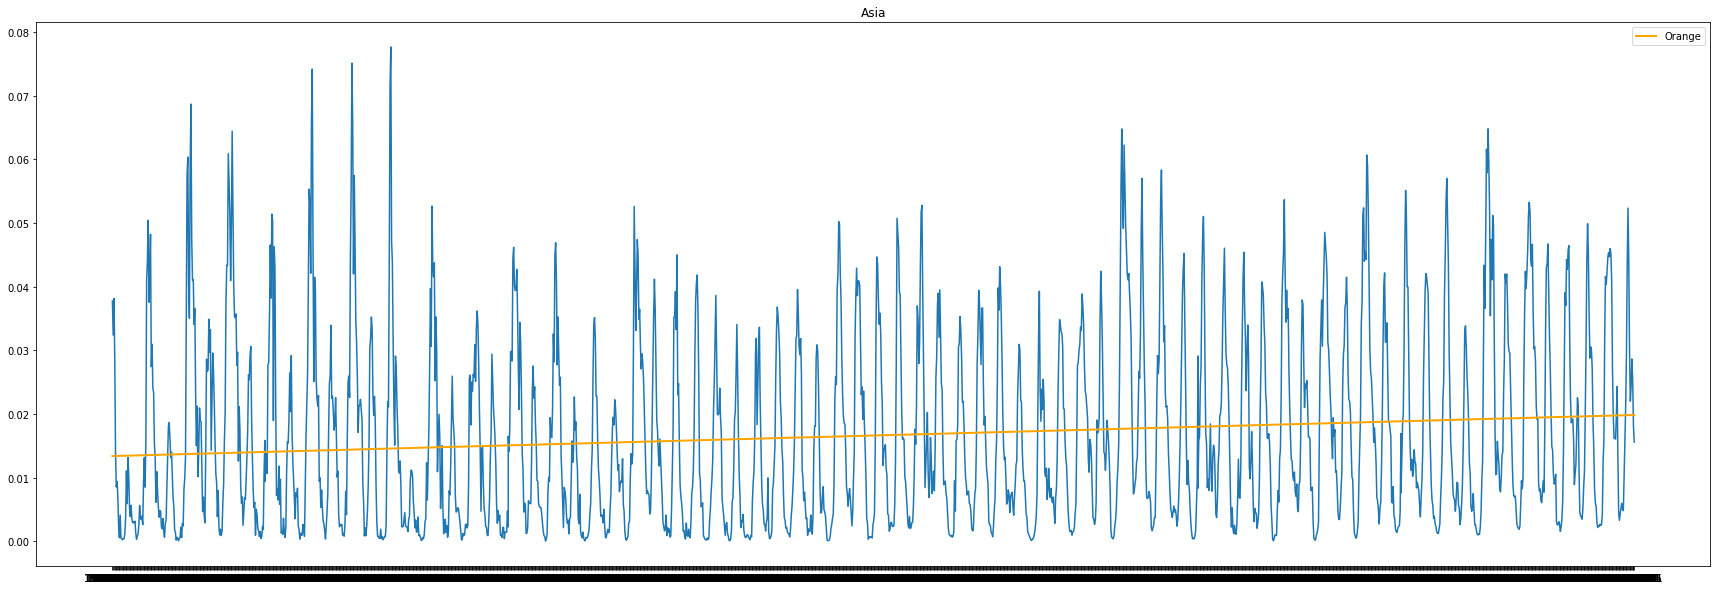

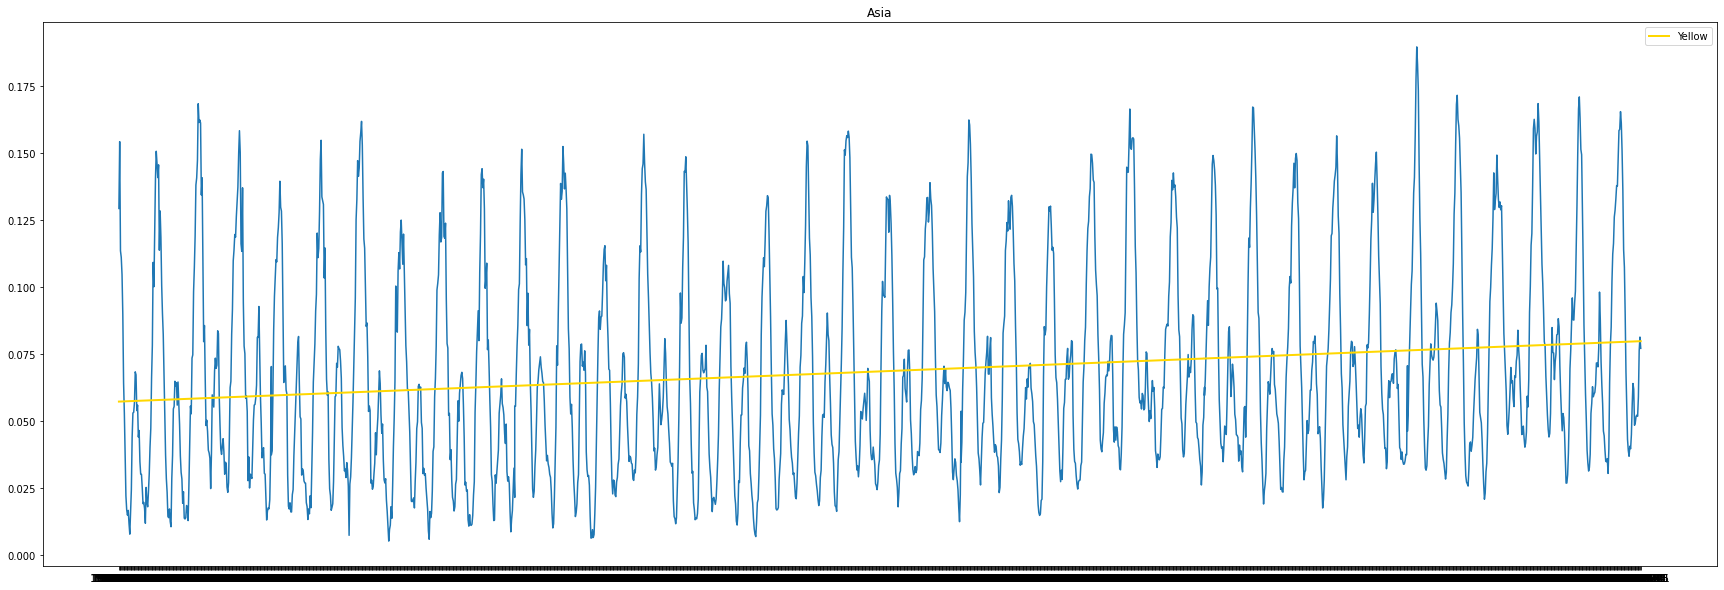

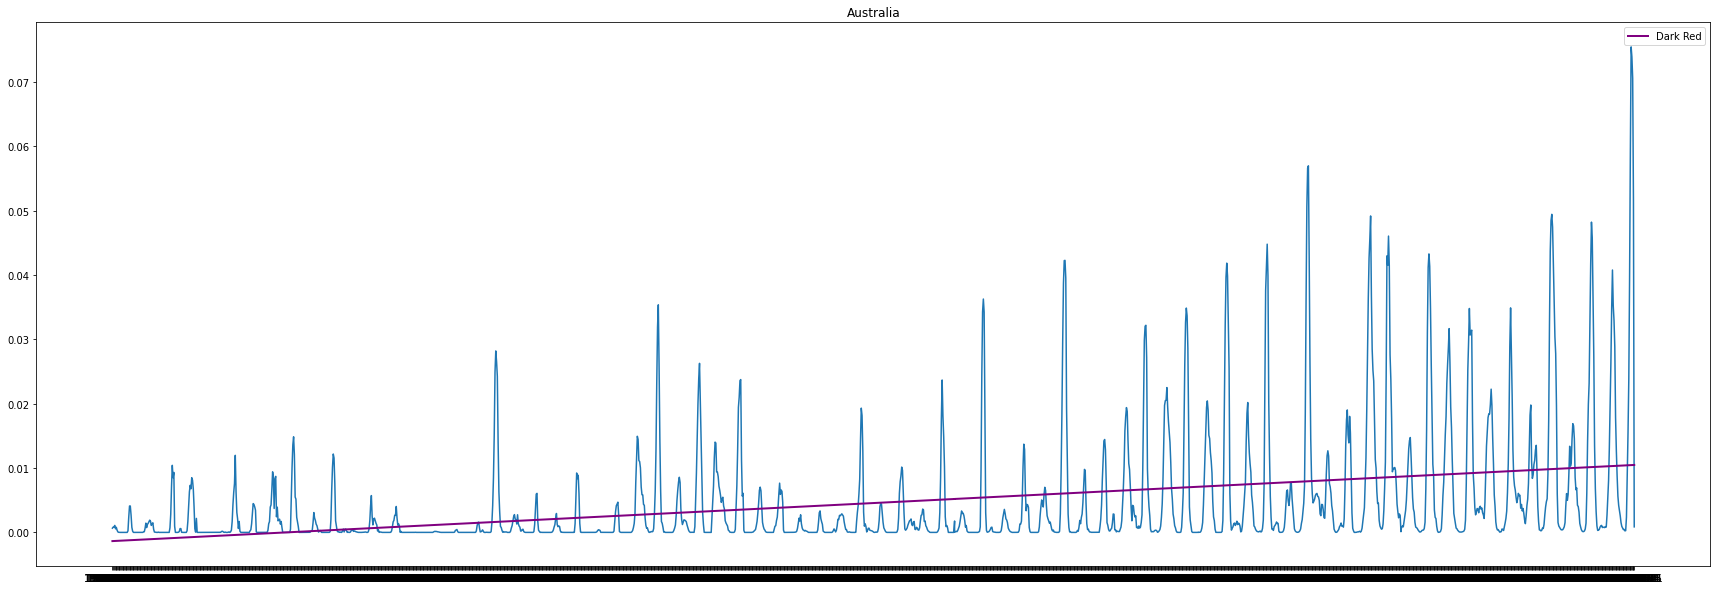

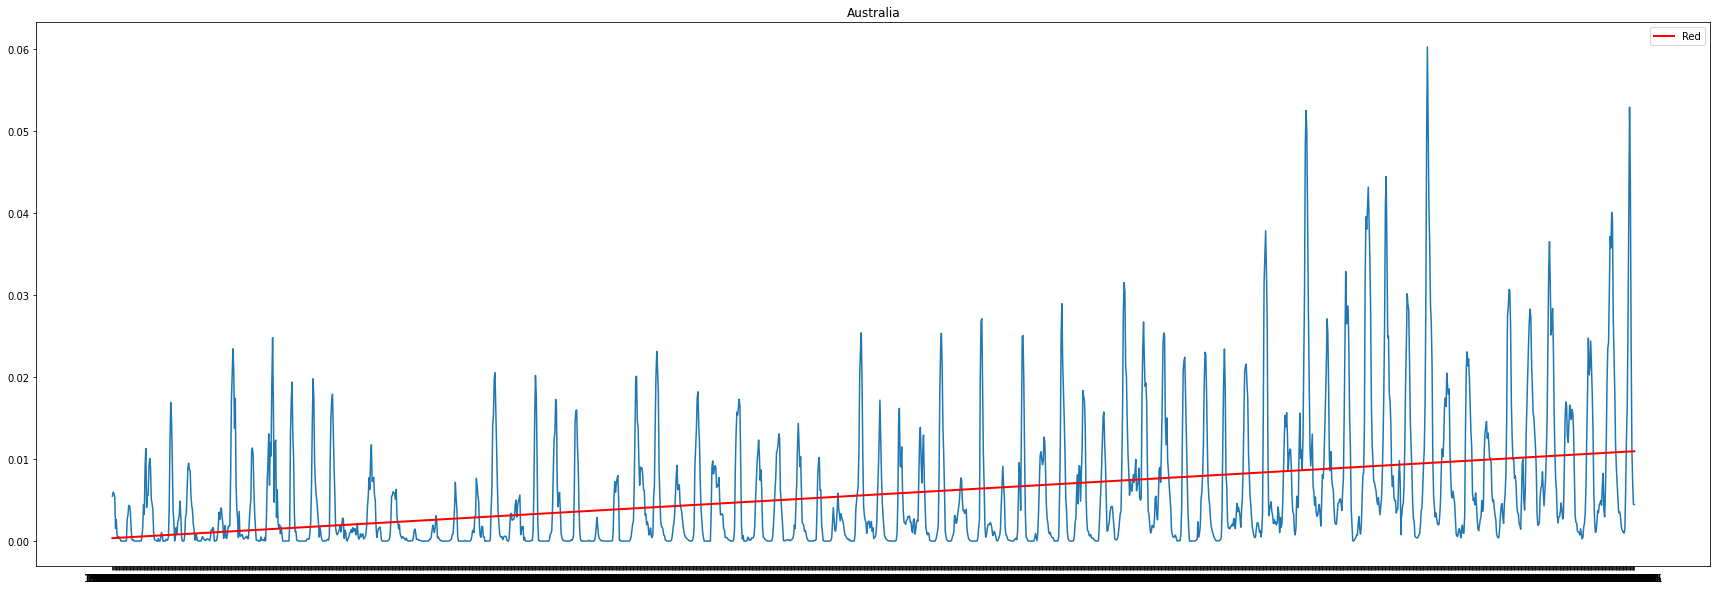

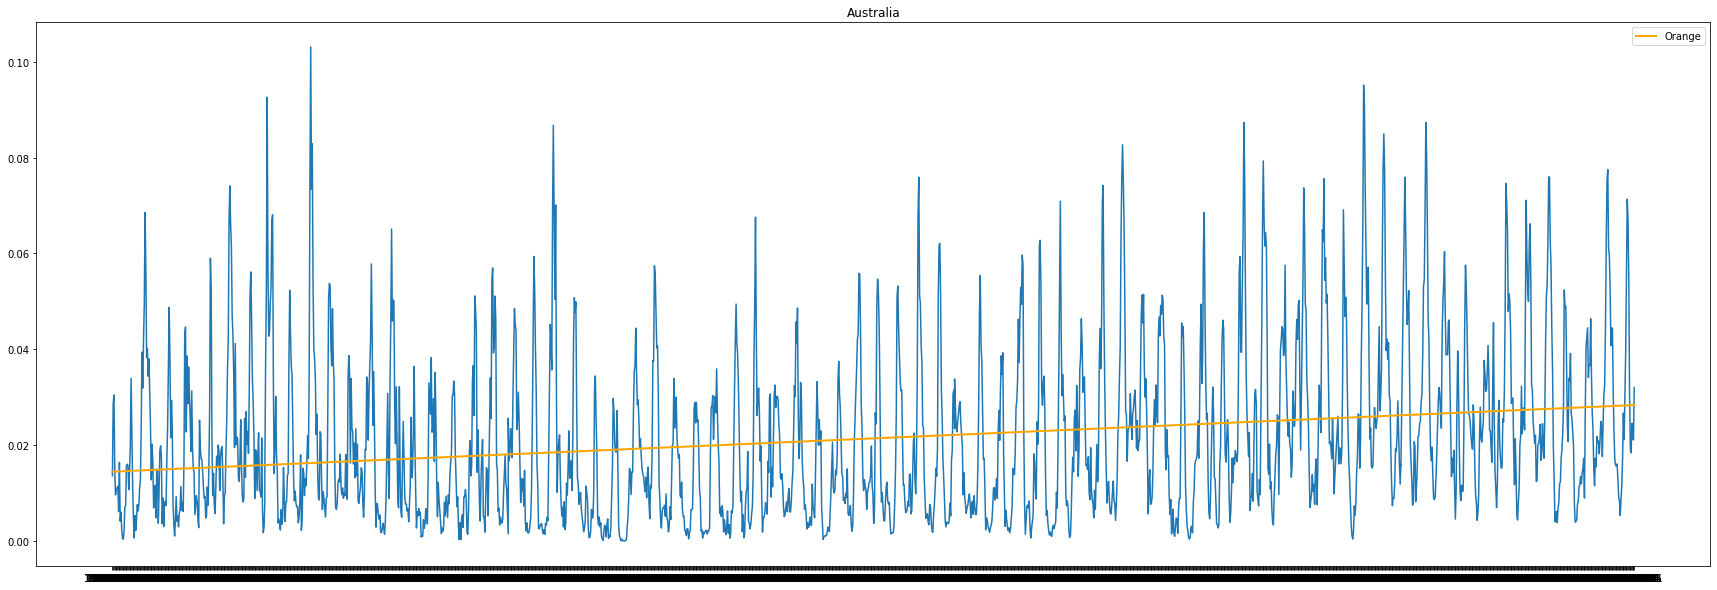

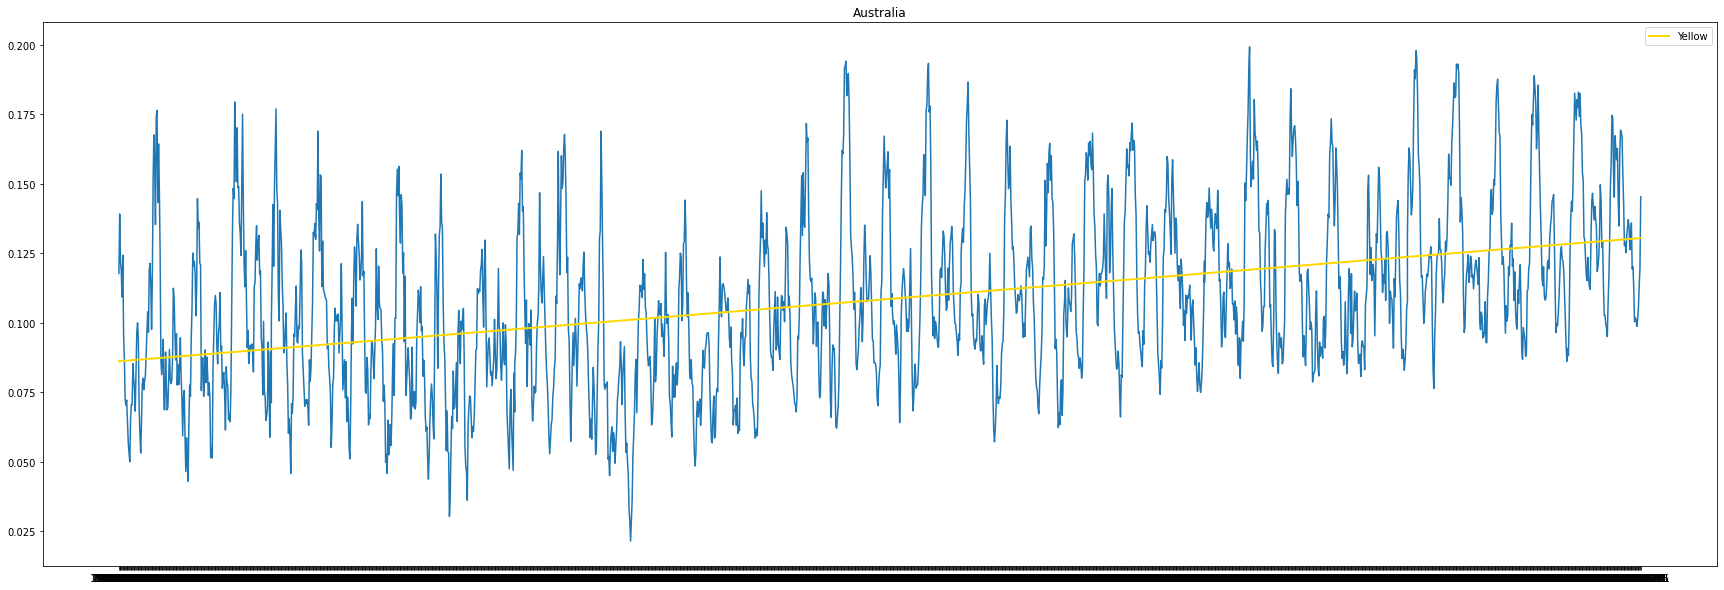

In [160]:
regions = ["Pacific","Asia","Australia"]


for region in range(len(regions)):

    color_wise_arr = [[],[],[],[]]
    j = 0
    to_zip1 = []
    to_zip1.append(np.asarray((dates)))

    for i in range(7):
        if i == 1 or i ==2 or i ==6:
            continue
        else:
            for year in range(len(region_data[region])):
                for day in range(len(region_data[region][year])):
                    color_wise_arr[j].append(region_data[region][year][day][i])
                    
            j += 1
    
    zippeed = []
    for i in range(len(dates)):
        zippeed.append([dates[i], color_wise_arr[0][i], color_wise_arr[1][i], color_wise_arr[2][i], color_wise_arr[3][i]])
    zippeed = np.array(zippeed)

    date_arr = zippeed[:,0]
    color_desc = ["Dark Red","Red", "Orange", "Yellow"]
    colors_line = ['purple','red', 'orange', 'gold',]

    for i in range(4):
        fig = plt.figure(figsize=(30,10))
        coeff = np.polyfit(range(len(date_arr)), zippeed[:,i+1].astype(float),1)
        poly1d = np.poly1d(coeff)
        x,y = (date_arr, poly1d(range(len(date_arr))))
        plt.plot(date_arr, zippeed[:,i+1].astype(float))
        plt.plot(x,y, label=color_desc[i], color =colors_line[i], linewidth=2.0)
        plt.title(regions[region])
        plt.legend()

    shape = np.shape(zippeed)
    with open(f'{regions[region]}_1.csv', 'w', ) as myfile:
        wr = csv.writer(myfile)
        wr.writerow(["Day", "Dark_red", "red", "orange", "yellow"])
        for i in range(shape[0]):
            wr.writerow(zippeed[i].T)

In [ ]:
# fig = plt.figure(figsize=(30,15))
# date_arr = zippeed[:,0]

# plt.plot(zippeed[:,0], zippeed[:,1].astype(float))


# coeff = np.polyfit(range(len(zippeed[:,0])), zippeed[:,1].astype(float),1)
# poly1d = np.poly1d(coeff)

# # fig = plt.figure(figsize=(30,15))
# # poly1d(range(len(zippeed[:,0])), '--k')
# x,y = (zippeed[:,0], poly1d(range(len(zippeed[:,0]))))
# plt.plot(x,y)